<center><font color="green" size="6"> <b>Sugarcane Yield Prediction using RS and ML<b> </font></center>
<center><img src="https://www.omex.com/wp-content/uploads/2020/10/Sugar-Cane-Harvest-1536x772.jpg" height="150"></center>

---

_Script elaborated by **Raul Roberto Poppiel**_ ([raulpoppiel@gmail.com](raulpoppiel@gmail.com)) for the [FAPESP](https://fapesp.br/en) project Nº [23/01062-1](https://bv.fapesp.br/en/bolsas/207973/satellite-imagery-and-machine-learning-for-sugarcane-yield-estimation-in-regions-of-sao-paulo-state/), led by Professor Ana Claudia dos Santos Luciano (analuciano@usp.br) from ESALQ/USP, Brazil. The methodology employed was developed by Rafaella Pironato Amaro ([rafaellapironato.amaro@gmail.com](rafaellapironato.amaro@gmail.com)) and is detailed in the document titled [Estimativa de produtividade da cana-de-açúcar a partir de imagens do satélite Sentinel-2A e o algoritmo de aprendizagem de máquina Random Forest](https://doi.org/10.11606/D.11.2023.tde-02102023-163947).

### Install and import tools

Data science modules

In [ ]:
# Load modules
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

print('Modules loaded')

Modules loaded


### Connect to GDrive

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set GDrive paths

Define the output folders in GD

In [ ]:
# Define folder names
folder_name_root = 'Colab Notebooks'
folder_name_project = 'sugarcane-yield-prediction'
folder_name_farm = '02_results'
folder_name_specific = '01_git_example'

In [ ]:
# Check if the folder exists or else create
root_path = f'/content/drive/MyDrive/{folder_name_root}'
project_path = f'{root_path}/{folder_name_project}'
farm_path = f'{project_path}/{folder_name_farm}'
out_path = f'{farm_path}/{folder_name_specific}' # your results will be stored in 'out_path'

if not os.path.exists(out_path):
  Path(out_path).mkdir(parents=True, exist_ok=True)
  print("Output directory created successfully.")
else:
  print("Output directory already exists.")

os.chdir(out_path)
print(os.getcwd(),'\n')  # Print the current working directory
print('List of files:\n', pd.DataFrame(os.listdir(), columns=["Files"])) # List files and directories in the current directory

Output directory created successfully.
/content/drive/MyDrive/Colab Notebooks/sugarcane-yield-prediction/02_results/01_git_example 

List of files:
 Empty DataFrame
Columns: [Files]
Index: []


# Yield prediction models

<center><img src="https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/machine-learning-algorithm.png" height="150"></center>

## Import Agronomic and RS dataset

In [ ]:
# Path to monthly data without outliers
test_all_path = os.path.join(project_path, f'01_input_data/sugarcane_data.csv')
test_all_path

'/content/drive/MyDrive/Colab Notebooks/sugarcane-yield-prediction/01_input_data/sugarcane_data.csv'

In [ ]:
# Import data without outliers
test_data_all = pd.read_csv(test_all_path)
test_data_all = test_data_all.set_index('ID_SIG')

# # Filter data by column "safra" equal to 1920
# test_data_all = test_data_all[test_data_all['SAFRA'] == CropSeason_data]

print(test_all_path,'\n')
print('Rows:',test_data_all.shape[0])
print('Columns:',test_data_all.shape[1],'\n')
test_data_all.head().style.set_caption('')

/content/drive/MyDrive/Colab Notebooks/sugarcane-yield-prediction/01_input_data/sugarcane_data.csv 

Rows: 417
Columns: 308 



,Unnamed: 0,Local,AREA,COD_USINA,CODFAZ,BLOCO,TALHAO,VARIEDADE,TCH_ANT,POL,TAH,Unidade_So,Ordem,relevo,EST_Corte,VAR,SAFRA_real,soloGeral,SAFRA,usina,12_temperature_2m,12_total_precipitation_sum,12_surface_solar_radiation_downwards_sum,01_temperature_2m,01_total_precipitation_sum,01_surface_solar_radiation_downwards_sum,02_temperature_2m,02_total_precipitation_sum,02_surface_solar_radiation_downwards_sum,03_temperature_2m,03_total_precipitation_sum,03_surface_solar_radiation_downwards_sum,01_ALT,01_ARMf,01_ARMi,01_Def,01_Def_rel,01_ETP,01_ETR,01_ETc,01_Exc,01_Kc,01_NAC,01_P_ETc,02_ALT,02_ARMf,02_ARMi,02_Def,02_Def_rel,02_ETP,02_ETR,02_ETc,02_Exc,02_Kc,02_NAC,02_P_ETc,03_ALT,03_ARMf,03_ARMi,03_Def,03_Def_rel,03_ETP,03_ETR,03_ETc,03_Exc,03_Kc,03_NAC,03_P_ETc,04_ALT,04_ARMf,04_ARMi,04_Def,04_Def_rel,04_ETP,04_ETR,04_ETc,04_Exc,04_Kc,04_NAC,04_P_ETc,05_ALT,05_ARMf,05_ARMi,05_Def,05_Def_rel,05_ETP,05_ETR,05_ETc,05_Exc,05_Kc,05_NAC,05_P_ETc,06_ALT,06_ARMf,06_ARMi,06_Def,06_Def_rel,06_ETP,06_ETR,06_ETc,06_Exc,06_Kc,06_NAC,06_P_ETc,07_ALT,07_ARMf,07_ARMi,07_Def,07_Def_rel,07_ETP,07_ETR,07_ETc,07_Exc,07_Kc,07_NAC,07_P_ETc,08_ALT,08_ARMf,08_ARMi,08_Def,08_Def_rel,08_ETP,08_ETR,08_ETc,08_Exc,08_Kc,08_NAC,08_P_ETc,09_ALT,09_ARMf,09_ARMi,09_Def,09_Def_rel,09_ETP,09_ETR,09_ETc,09_Exc,09_Kc,09_NAC,09_P_ETc,10_ALT,10_ARMf,10_ARMi,10_Def,10_Def_rel,10_ETP,10_ETR,10_ETc,10_Exc,10_Kc,10_NAC,10_P_ETc,11_ALT,11_ARMf,11_ARMi,11_Def,11_Def_rel,11_ETP,11_ETR,11_ETc,11_Exc,11_Kc,11_NAC,11_P_ETc,12_ALT,12_ARMf,12_ARMi,12_Def,12_Def_rel,12_ETP,12_ETR,12_ETc,12_Exc,12_Kc,12_NAC,12_P_ETc,13_ALT,13_ARMf,13_ARMi,13_Def,13_Def_rel,13_ETP,13_ETR,13_ETc,13_Exc,13_Kc,13_NAC,13_P_ETc,14_ALT,14_ARMf,14_ARMi,14_Def,14_Def_rel,14_ETP,14_ETR,14_ETc,14_Exc,14_Kc,14_NAC,14_P_ETc,15_ALT,15_ARMf,15_ARMi,15_Def,15_Def_rel,15_ETP,15_ETR,15_ETc,15_Exc,15_Kc,15_NAC,15_P_ETc,12_NDVI,12_EVI,12_SAVI,12_NDMI,12_NDWI1,12_NDWI2,12_NDVIre1,12_NDVIre2,12_NDVIre3,12_CIre1,12_CIre2,12_CIre3,12_MSRre1,12_MSRre2,12_MSRre3,12_SIWSI,12_red,12_nir,12_swir1,12_swir2,12_rededge1,12_rededge2,12_rededge3,12_nir8A,01_NDVI,01_EVI,01_SAVI,01_NDMI,01_NDWI1,01_NDWI2,01_NDVIre1,01_NDVIre2,01_NDVIre3,01_CIre1,01_CIre2,01_CIre3,01_MSRre1,01_MSRre2,01_MSRre3,01_SIWSI,01_red,01_nir,01_swir1,01_swir2,01_rededge1,01_rededge2,01_rededge3,01_nir8A,02_NDVI,02_EVI,02_SAVI,02_NDMI,02_NDWI1,02_NDWI2,02_NDVIre1,02_NDVIre2,02_NDVIre3,02_CIre1,02_CIre2,02_CIre3,02_MSRre1,02_MSRre2,02_MSRre3,02_SIWSI,02_red,02_nir,02_swir1,02_swir2,02_rededge1,02_rededge2,02_rededge3,02_nir8A,03_NDVI,03_EVI,03_SAVI,03_NDMI,03_NDWI1,03_NDWI2,03_NDVIre1,03_NDVIre2,03_NDVIre3,03_CIre1,03_CIre2,03_CIre3,03_MSRre1,03_MSRre2,03_MSRre3,03_SIWSI,03_red,03_nir,03_swir1,03_swir2,03_rededge1,03_rededge2,03_rededge3,03_nir8A
ID_SIG,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
X21220280001017700000008,12736,Usina 1,0.507863,28,177,0,8,CT961007,100.920000,14.840000,14.858450,PVA19,Argissolos,Ondulado,1,CT961007,2021,PV,2122,M1,23.975798,235.497159,641.044228,24.470726,186.000658,684.306524,23.871414,144.957491,598.969728,24.156788,97.690545,635.507971,0.000000,62.858883,62.858883,-0.183903,-0.050633,4.779353,4.485320,4.301418,4.416431,0.900000,-3.346001,3.365267,0.000000,64.744157,64.744157,0.307423,0.062686,3.768977,2.978561,3.285985,3.711201,0.874138,-1.322217,3.362384,-0.323230,61.111495,61.434725,0.876604,0.096314,4.411999,2.558649,3.435253,1.055086,0.772581,-4.624480,-0.801267,0.234314,61.923589,61.689275,0.558933,0.019431,3.465970,1.515152,2.074085,0.000000,0.586667,-3.825991,-1.512868,-0.009125,63.096096,63.105220,0.771384,-0.056912,2.303767,0.729819,1.501203,0.376849,0.664516,-2.750228,-0.735532,-0.016702,63.003478,63.020180,1.002929,0.501973,2.027689,0.800371,1.803300,-0.164838

## Define the variables for modelling

In [ ]:
# Define the dependent variable that will be predicted [y]
y_variable_dependent = 'TCH_ANT'

# Define the independent variables that will be used for prediction [f(x)]
x_variables_categorical = 'EST_Corte|VARIEDADE|Ordem'
x_variables_numerical_climate = 'temperature_2m|total_precipitation_sum|surface_solar_radiation_downwards_sum'
x_variables_numerical_hb = 'Def|Def_rel'
x_variables_numerical_sentinel = 'CIre1|CIre2|CIre3|EVI|MSRre1|MSRre2|MSRre3|NDMI|NDVI|NDVIre1|NDVIre2|NDVIre3|NDWI1|NDWI2|nir|nir8A|red|rededge1|rededge2|rededge3|SAVI|SIWSI|swir1|swir2'

In [ ]:
# Print variable names
x_variables_independent = x_variables_categorical +'|'+ x_variables_numerical_climate +'|'+ x_variables_numerical_hb +'|'+ x_variables_numerical_sentinel
print('y_variable_dependent:',y_variable_dependent,'\n')
display('x_variables_independent:',x_variables_independent)

# Select variables for modelling that match any characters in the dataset
variables_for_modelling = test_data_all.loc[:, test_data_all.columns.str.contains(y_variable_dependent +'|'+ x_variables_independent)]
variables_for_modelling

y_variable_dependent: TCH_ANT 



'x_variables_independent:'

'EST_Corte|VARIEDADE|Ordem|temperature_2m|total_precipitation_sum|surface_solar_radiation_downwards_sum|Def|Def_rel|CIre1|CIre2|CIre3|EVI|MSRre1|MSRre2|MSRre3|NDMI|NDVI|NDVIre1|NDVIre2|NDVIre3|NDWI1|NDWI2|nir|nir8A|red|rededge1|rededge2|rededge3|SAVI|SIWSI|swir1|swir2'

,VARIEDADE,TCH_ANT,Ordem,EST_Corte,12_temperature_2m,12_total_precipitation_sum,12_surface_solar_radiation_downwards_sum,01_temperature_2m,01_total_precipitation_sum,01_surface_solar_radiation_downwards_sum,...,03_MSRre3,03_SIWSI,03_red,03_nir,03_swir1,03_swir2,03_rededge1,03_rededge2,03_rededge3,03_nir8A
ID_SIG,,,,,,,,,,,,,,,,,,,,,
X21220280001017700000008,CT961007,100.92,Argissolos,1,23.975798,235.497159,641.044228,24.470726,186.000658,684.306524,...,-0.009952,0.268020,0.010395,0.048532,0.030044,0.017358,0.017482,0.040380,0.049132,0.052388
X21220280001018000000002,CT961007,83.02,Latossolos,1,24.395783,226.685387,639.770436,24.931532,167.362301,685.919252,...,-0.009211,0.296815,0.008020,0.050356,0.029658,0.016129,0.015793,0.041208,0.050888,0.054545
X19200280001015400000002,CT961007,86.36,Neossolos,1,24.203365,121.901401,731.410308,25.553384,92.606430,762.886612,...,-0.003510,0.372522,0.007399,0.056553,0.028085,0.013570,0.016227,0.046688,0.056880,0.061492
X21220280001003200000003,CT961007,70.97,Nitossolos,1,24.216946,210.612578,641.036908,24.773426,166.693015,686.094612,...,-0.015061,0.222662,0.010613,0.047293,0.032589,0.019544,0.018328,0.040114,0.048294,0.051920
X21220280001004700000013,CT961007. CTC4,94.98,Latossolos,1,24.108077,206.490350,641.843960,24.662746,156.620337,684.607244,...,-0.013406,0.422582,0.005832,0.058765,0.025790,0.010992,0.013591,0.046049,0.059981,0.063121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X19200720000237000020042,SP911285,48.22,Argissolos,5,26.599747,93.402602,746.900200,28.080074,70.855608,766.459768,...,-0.013978,0.321473,0.008909,0.061220,0.033791,0.017127,0.017801,0.050554,0.061655,0.065987
X20210720000237000010009,SP911285,61.70,Latossolos,5,25.968431,143.401424,654.868840,26.154083,249.678982,684.404150,...,-0.003634,0.353538,0.008131,0.062798,0.031853,0.015741,0.017909,0.050969,0.063600,0.067002
X19200280001008100000007,Sem inf,55.49,Latossolos,5,25.639718,93.893402,730.236904,26.951641,80.129837,762.018448,...,-0.018742,0.392354,0.005276,0.068624,0.031797,0.015957,0.016135,0.057831,0.070672,0.073675


n total: 417


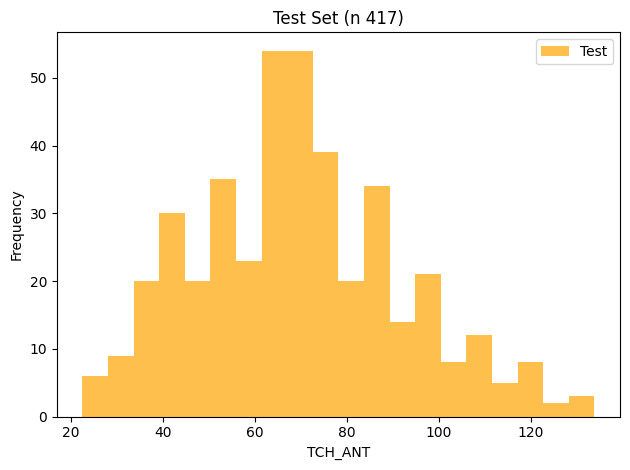

In [ ]:
print('n total:', variables_for_modelling.shape[0])

# Plot histograms for test set
plt.hist(variables_for_modelling[y_variable_dependent], bins=20, color='orange', alpha=0.7, label='Test')
plt.title(f'Test Set (n {variables_for_modelling.shape[0]})')
plt.xlabel(y_variable_dependent)
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(f'{out_path}/Global_model_histogram.png', dpi=350, bbox_inches='tight')

plt.show()

## Load model and check variables

In [ ]:
# from sklearn.externals import joblib
from joblib import dump, load

model_filename = os.path.join(project_path, f'01_input_data/01_model_global.joblib')
model_filename

'/content/drive/MyDrive/Colab Notebooks/sugarcane-yield-prediction/01_input_data/01_model_global.joblib'

In [ ]:
# Load the optimal model from Google Drive
loaded_model = load(model_filename)

# Features used to test the model
x_test_data = variables_for_modelling.drop(columns=[y_variable_dependent])
# One hot encoding categorical variables
x_test_data_missing = pd.get_dummies(x_test_data, columns=x_variables_categorical.split('|'))
# Target variable
y_test_data = variables_for_modelling[y_variable_dependent]

In [ ]:
# Extract feature names from the model
if hasattr(loaded_model, 'feature_names_in_'):
    feature_names_model = loaded_model.feature_names_in_
else:
    raise ValueError("Feature names extraction is not supported for this model type.")

# Check and compare feature names with the input DataFrame
missing_features = [feature for feature in feature_names_model if feature not in x_test_data_missing.columns]
print("Missing features:", len(missing_features))
print("Missing features added (with value=0):", len(missing_features))
print(missing_features)

# Add missing features to the input DataFrame with zero values
for feature in missing_features:
    x_test_data_missing[feature] = 0

# Sort the columns of the DataFrame to match the order in feature_names_model
x_test_data = x_test_data_missing.reindex(columns=feature_names_model)

print('\n')
x_test_data

Missing features: 0
Missing features added (with value=0): 0
[]




,12_temperature_2m,12_total_precipitation_sum,12_surface_solar_radiation_downwards_sum,01_temperature_2m,01_total_precipitation_sum,01_surface_solar_radiation_downwards_sum,02_temperature_2m,02_total_precipitation_sum,02_surface_solar_radiation_downwards_sum,03_temperature_2m,...,VARIEDADE_SP87365,VARIEDADE_SP911285,VARIEDADE_Sem inf,VARIEDADE_a def,VARIEDADE_viveiro,Ordem_Argissolos,Ordem_Gleissolos,Ordem_Latossolos,Ordem_Neossolos,Ordem_Nitossolos
ID_SIG,,,,,,,,,,,,,,,,,,,,,
X21220280001017700000008,23.975798,235.497159,641.044228,24.470726,186.000658,684.306524,23.871414,144.957491,598.969728,24.156788,...,0,0,0,0,0,1,0,0,0,0
X21220280001018000000002,24.395783,226.685387,639.770436,24.931532,167.362301,685.919252,24.402379,138.363176,596.648810,24.658607,...,0,0,0,0,0,0,0,1,0,0
X19200280001015400000002,24.203365,121.901401,731.410308,25.553384,92.606430,762.886612,24.169240,225.495147,537.091058,22.810921,...,0,0,0,0,0,0,0,0,1,0
X21220280001003200000003,24.216946,210.612578,641.036908,24.773426,166.693015,686.094612,24.327053,127.424308,597.628376,24.556769,...,0,0,0,0,0,0,0,0,0,1
X21220280001004700000013,24.108077,206.490350,641.843960,24.662746,156.620337,684.607244,24.260600,123.251417,596.152180,24.451969,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X19200720000237000020042,26.599747,93.402602,746.900200,28.080074,70.855608,766.459768,26.429709,205.210256,548.437362,25.136466,...,0,1,0,0,0,1,0,0,0,0
X20210720000237000010009,25.968431,143.401424,654.868840,26.154083,249.678982,684.404150,24.909240,178.145947,507.260995,25.174718,...,0,1,0,0,0,0,0,1,0,0
X19200280001008100000007,25.639718,93.893402,730.236904,26.951641,80.129837,762.018448,25.518405,209.181371,538.208072,23.903768,...,0,0,1,0,0,0,0,1,0,0


### Predict and evaluate

In [ ]:
# Make predictions using the loaded model
test_predictions = loaded_model.predict(x_test_data)

In [ ]:
# Validation and performance metrics using external dataset
r2 = r2_score(y_test_data, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test_data, test_predictions))
rpiq = 1 / (rmse / np.std(y_test_data))

# Round metric values to two decimal places
r2 = round(r2, 2)
rmse = round(rmse, 2)
rpiq = round(rpiq, 2)

# Create a DataFrame from the performance metrics
metrics_data = {'Metric': ['R2 Score', 'RMSE', 'RPIQ'],
                'Value': [r2, rmse, rpiq]}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Metric,Value
0,R2 Score,0.71
1,RMSE,11.88
2,RPIQ,1.87


In [ ]:
# Save metrics of validation
metrics_path = os.path.join(out_path, f'Model_global_validation.csv')
metrics_df.to_csv(metrics_path, encoding='utf-8', index=False)

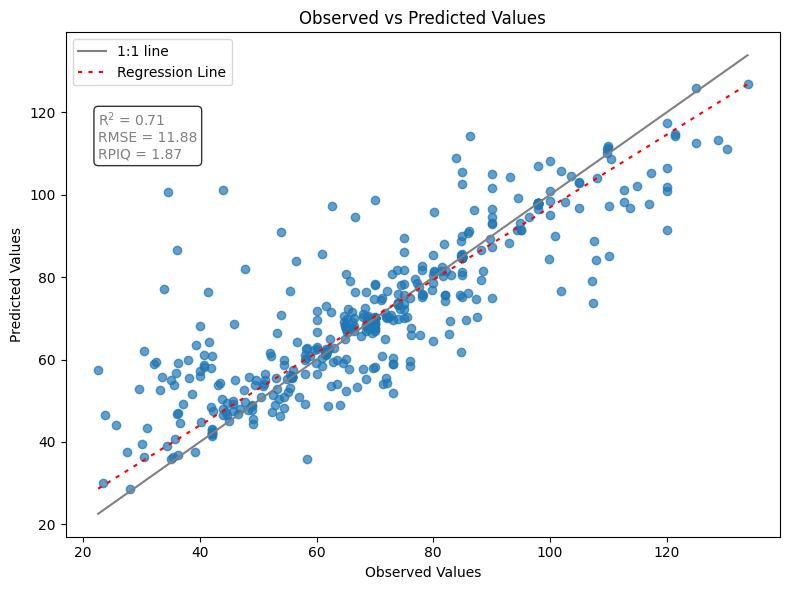

In [ ]:
# Scatterplot of observed vs predicted values with annotations
plt.figure(figsize=(8, 6))
plt.scatter(y_test_data, test_predictions, alpha=0.7)
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs Predicted Values')

# Draw the 1:1 line (45-degree line)
plt.plot([min(y_test_data), max(y_test_data)], [min(y_test_data), max(y_test_data)], color='gray', label='1:1 line')

# Calculate the coordinates for the regression line
regression_line_x = [min(y_test_data), max(y_test_data)]
regression_line_y = [min(test_predictions), max(test_predictions)]

# Create a box to hold R2, RMSE, and RPIQ in the top left corner
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
textstr = f'R$^2$ = {r2:.2f}\nRMSE = {rmse:.2f}\nRPIQ = {rpiq:.2f}'
plt.text(min(y_test_data), max(test_predictions*0.95), textstr, color='gray', bbox=box_props, verticalalignment='top', horizontalalignment='left')

# Draw the regression line
plt.plot(regression_line_x, regression_line_y, linestyle=(0, (2, 3)), color='red', label='Regression Line')
# linestyles: https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html

# Show the legend with the regression line
plt.legend()

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(f'{out_path}/Model_global_obs_pred_scatterplot.png', dpi=350, bbox_inches='tight')

plt.show()

### Residuals

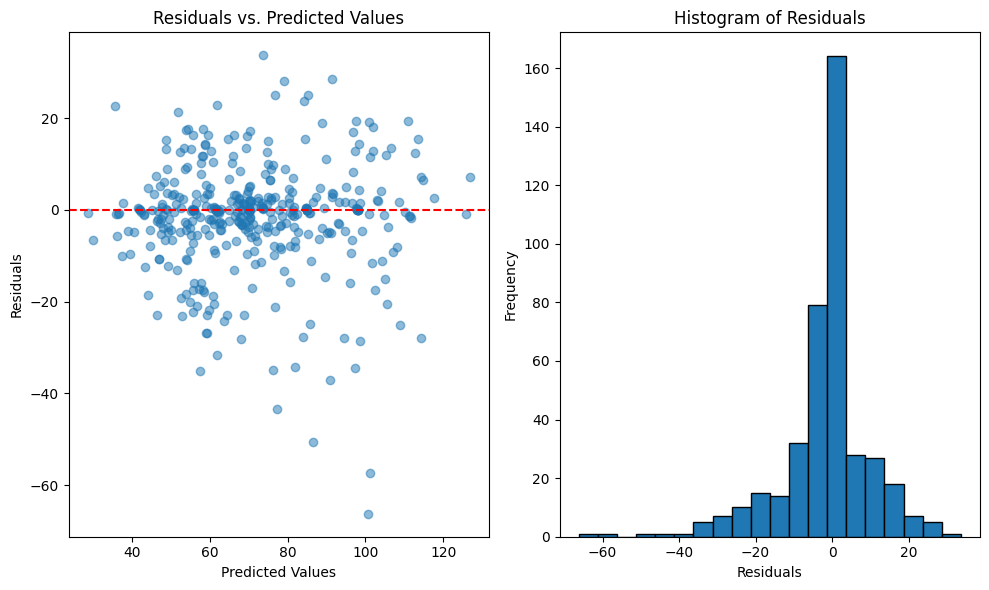

In [ ]:
# Calculate residuals
residuals = y_test_data - test_predictions

# Residual analysis
plt.figure(figsize=(10, 6))

# Scatter plot of predicted values vs. residuals
plt.subplot(1, 2, 1)
plt.scatter(test_predictions, residuals,  alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(f'{out_path}/Model_global_residuals.png', dpi=350, bbox_inches='tight')

plt.show()

## Predictors importance

In [ ]:
# Set the value of importance to filter variables
importance_greater_than = 0

# Get values
importances = loaded_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in loaded_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Filter features with importance higher than zero
selected_indices = indices[importances[indices] > importance_greater_than]

# Create a DataFrame from the selected importance values
importance_data = {'Feature': [x_test_data.columns[i] for i in selected_indices],
                   'Importance': importances[selected_indices],
                   'Standard Deviation': std[selected_indices]}

importance_df = pd.DataFrame(importance_data)

# Save to GDrive
importance_df.to_csv(f'{out_path}/Model_global_features_importance.csv', encoding='utf-8', index=False)
print(f'Importances greater than {importance_greater_than} saved!\n')

importance_df

Importances greater than 0 saved!



,Feature,Importance,Standard Deviation
0,EST_Corte_1,0.152997,0.039519
1,12_NDMI,0.132657,0.123232
2,EST_Corte_2,0.092981,0.014181
3,02_surface_solar_radiation_downwards_sum,0.072522,0.026262
4,01_NDVIre1,0.036545,0.086363
...,...,...,...
193,VARIEDADE_CTC17,0.000003,0.000022
194,VARIEDADE_IACSP974039,0.000002,0.000024
195,VARIEDADE_RB985476,0.000002,0.000013
196,VARIEDADE_CV0618,0.000002,0.000019


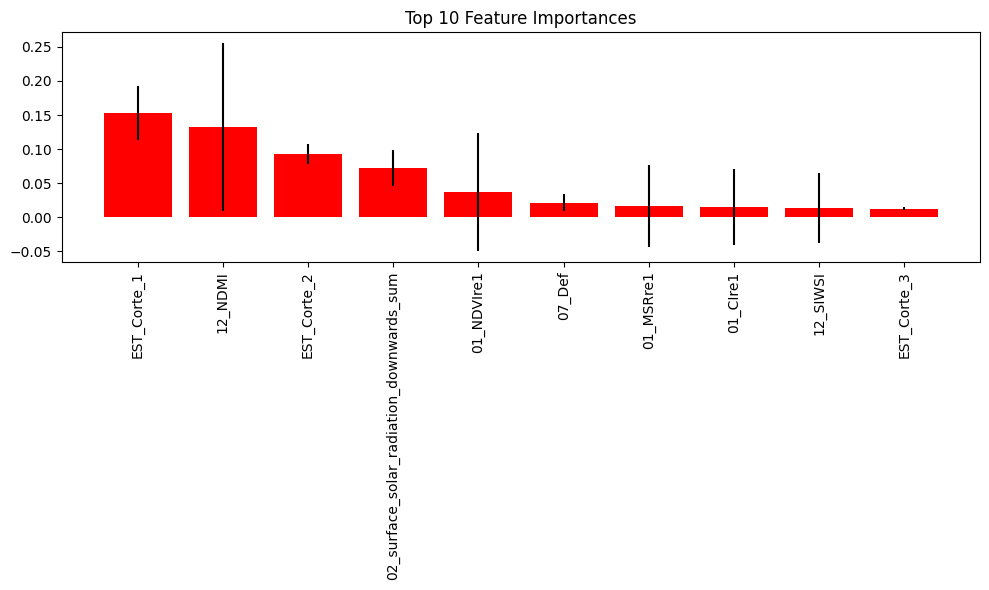

In [ ]:
# Plotting the most important variables
num_of_features = 10 # Define the amount of features to plot

importances = loaded_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in loaded_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:num_of_features]

plt.figure(figsize=(10, 6))  # Adjust the width as needed
plt.title(f"Top {num_of_features} Feature Importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [x_test_data.columns[i] for i in indices], rotation='vertical')

plt.tight_layout()  # Ensure proper spacing

# Save the plot as a PNG image
plt.savefig(f'{out_path}/Model_global_features_importance.png', dpi=350, bbox_inches='tight')

plt.show()